In [2]:
import cv2
import pytesseract
from PIL import Image, ImageDraw, ImageFont
import numpy as np

In [3]:
test_image = "/Users/junaid/Documents/projects/SpaceMarvel/owl-masker/samples/d2362696da9a407b0c10e145c132df71.jpg"

d1 = pytesseract.image_to_data(test_image)

In [25]:
import cv2
import pytesseract
from PIL import Image, ImageDraw, ImageFont
import re
import numpy as np
import pandas as pd
from datetime import datetime
import json

# Configure tesseract path if needed
# pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract'

class FixedAadhaarMasker:
    def __init__(self, image_path):
        self.image_path = image_path
        self.image = cv2.imread(image_path)
        self.pil_image = Image.open(image_path)
        self.height, self.width = self.image.shape[:2]
        
        # Comprehensive exclusion list
        self.excluded_words = [
            'government', 'india', 'bharti', 'unique', 'identification', 'authority',
            'uidai', 'aadhaar', 'aadhar', 'male', 'female', 'dob', 'vid', 'address',
            'help', 'www', 'gov', 'pin', 'post', 'district', 'state', 'instructions',
            'proof', 'identity', 'citizenship', 'authenticate', 'online', 'children',
            'biometric', 'information', 'sample', 'specimen', 'enrollment'
        ]
    
    def preprocess_image(self):
        """Enhanced image preprocessing for better OCR"""
        gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
        
        processed_images = []
        
        # Original grayscale
        processed_images.append(gray)
        
        # Gaussian blur to reduce noise
        blurred = cv2.GaussianBlur(gray, (3, 3), 0)
        processed_images.append(blurred)
        
        # Adaptive thresholding
        adaptive = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
        processed_images.append(adaptive)
        
        # OTSU thresholding
        _, otsu = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        processed_images.append(otsu)
        
        return processed_images
    
    def extract_text_with_positions(self):
        """Extract text with comprehensive OCR approach"""
        processed_images = self.preprocess_image()
        all_results = []
        
        # Multiple OCR configurations for better coverage
        configs = [
            '--psm 6 -l eng+hin',   # Uniform block
            '--psm 11 -l eng+hin',  # Sparse text  
            '--psm 3 -l eng+hin',   # Auto page segmentation
            '--psm 6 -l eng',       # English only uniform
            '--psm 11 -l eng'       # English only sparse
        ]
        
        for img in processed_images:
            for config in configs:
                try:
                    data = pytesseract.image_to_data(img, output_type=pytesseract.Output.DICT, config=config)
                    
                    for i in range(len(data['text'])):
                        conf = int(data['conf'][i])
                        text = data['text'][i].strip()
                        
                        # Lower confidence threshold for challenging cards
                        if conf > 15 and text and len(text) >= 1:
                            if not (len(text) == 1 and text in '.,;:|"\'`'):
                                all_results.append({
                                    'text': text,
                                    'x': data['left'][i],
                                    'y': data['top'][i],
                                    'w': data['width'][i],
                                    'h': data['height'][i],
                                    'confidence': conf
                                })
                except Exception:
                    continue
        
        return self.remove_duplicates(all_results)
    
    def remove_duplicates(self, results):
        """Remove duplicate OCR results"""
        if not results:
            return []
        
        # Sort by confidence (highest first)
        results = sorted(results, key=lambda x: x['confidence'], reverse=True)
        
        filtered = []
        tolerance = 15
        
        for result in results:
            is_duplicate = False
            for existing in filtered:
                # Check overlap
                x_overlap = not (result['x'] + result['w'] < existing['x'] or 
                               existing['x'] + existing['w'] < result['x'])
                y_overlap = not (result['y'] + result['h'] < existing['y'] or 
                               existing['y'] + existing['h'] < result['y'])
                
                if (x_overlap and y_overlap and 
                    abs(result['x'] - existing['x']) < tolerance and
                    abs(result['y'] - existing['y']) < tolerance):
                    is_duplicate = True
                    break
            
            if not is_duplicate:
                filtered.append(result)
        
        return filtered
    
    def filter_instruction_text(self, ocr_results):
        """Filter out instruction text and focus on actual card"""
        # For instruction cards, focus on right side
        card_threshold = self.width * 0.4
        
        filtered = []
        instruction_keywords = [
            'instructions', 'aadhaar is proof', 'establish identity',
            'authenticate online', 'help is required', 'children',
            'proof of identity', 'not of citizenship', 'specimen', 'sample'
        ]
        
        for result in ocr_results:
            text_lower = result['text'].lower()
            
            # Skip instruction text
            if any(keyword in text_lower for keyword in instruction_keywords):
                continue
            
            # Prefer right side for instruction cards
            if result['x'] > card_threshold:
                filtered.append(result)
            elif not any(keyword in text_lower for keyword in instruction_keywords):
                filtered.append(result)
        
        return filtered
    
    def verify_aadhaar_checksum(self, number):
        """Verify Aadhaar number using Verhoeff checksum"""
        multiplication_table = (
            (0, 1, 2, 3, 4, 5, 6, 7, 8, 9),
            (1, 2, 3, 4, 0, 6, 7, 8, 9, 5),
            (2, 3, 4, 0, 1, 7, 8, 9, 5, 6),
            (3, 4, 0, 1, 2, 8, 9, 5, 6, 7),
            (4, 0, 1, 2, 3, 9, 5, 6, 7, 8),
            (5, 9, 8, 7, 6, 0, 4, 3, 2, 1),
            (6, 5, 9, 8, 7, 1, 0, 4, 3, 2),
            (7, 6, 5, 9, 8, 2, 1, 0, 4, 3),
            (8, 7, 6, 5, 9, 3, 2, 1, 0, 4),
            (9, 8, 7, 6, 5, 4, 3, 2, 1, 0)
        )
        
        permutation_table = (
            (0, 1, 2, 3, 4, 5, 6, 7, 8, 9),
            (1, 5, 7, 6, 2, 8, 3, 0, 9, 4),
            (5, 8, 0, 3, 7, 9, 6, 1, 4, 2),
            (8, 9, 1, 6, 0, 4, 3, 5, 2, 7),
            (9, 4, 5, 3, 1, 2, 6, 8, 7, 0),
            (4, 2, 8, 6, 5, 7, 3, 9, 0, 1),
            (2, 7, 9, 3, 8, 0, 6, 4, 1, 5),
            (7, 0, 4, 6, 9, 1, 3, 2, 5, 8)
        )
        
        try:
            number_tuple = tuple(int(n) for n in reversed(str(number)))
            checksum = 0
            
            for i, n in enumerate(number_tuple):
                checksum = multiplication_table[checksum][permutation_table[i % 8][n]]
            
            return checksum == 0 and int(number) % 10000 != 1947
        except:
            return False
    
    def identify_aadhaar_numbers(self, ocr_results):
        """Identify Aadhaar numbers with multiple strategies"""
        aadhaar_matches = []
        filtered_results = self.filter_instruction_text(ocr_results)
        
        # Strategy 1: Complete patterns
        patterns = [
            r'\b\d{4}\s+\d{4}\s+\d{4}\b',  # XXXX XXXX XXXX
            r'\b\d{4}\s*\d{4}\s*\d{4}\b',  # Flexible spacing
            r'\b\d{12}\b'                   # No spaces
        ]
        
        for result in filtered_results:
            for pattern in patterns:
                matches = re.finditer(pattern, result['text'])
                for match in matches:
                    number_str = re.sub(r'\D', '', match.group())
                    if len(number_str) == 12 and self.verify_aadhaar_checksum(number_str):
                        # Calculate position
                        match_start = match.start()
                        match_end = match.end()
                        char_width = result['w'] / len(result['text']) if len(result['text']) > 0 else 10
                        
                        bbox_x = result['x'] + int(match_start * char_width)
                        bbox_w = int((match_end - match_start) * char_width)
                        
                        aadhaar_matches.append({
                            'type': 'aadhaar_number',
                            'text': match.group(),
                            'bbox': [bbox_x, result['y'], bbox_w, result['h']],
                            'confidence': result['confidence']
                        })
        
        # Strategy 2: Split numbers
        if not aadhaar_matches:
            aadhaar_matches.extend(self.find_split_aadhaar_numbers(filtered_results))
        
        return aadhaar_matches
    
    def find_split_aadhaar_numbers(self, ocr_results):
        """Find Aadhaar numbers split across multiple text elements"""
        matches = []
        sorted_results = sorted(ocr_results, key=lambda x: (x['y'], x['x']))
        
        for i, result in enumerate(sorted_results):
            if re.match(r'^\d{4}$', result['text']):
                candidates = [result]
                
                # Look for next parts
                for j in range(i + 1, min(i + 5, len(sorted_results))):
                    next_result = sorted_results[j]
                    
                    if (abs(next_result['y'] - result['y']) < 20 and 
                        re.match(r'^\d{4}$', next_result['text']) and
                        next_result['x'] > result['x']):
                        candidates.append(next_result)
                        
                        if len(candidates) == 3:
                            number_str = ''.join(c['text'] for c in candidates)
                            if self.verify_aadhaar_checksum(number_str):
                                # Combined bounding box
                                min_x = min(c['x'] for c in candidates)
                                max_x = max(c['x'] + c['w'] for c in candidates)
                                min_y = min(c['y'] for c in candidates)
                                max_y = max(c['y'] + c['h'] for c in candidates)
                                
                                matches.append({
                                    'type': 'aadhaar_number',
                                    'text': f"{candidates[0]['text']} {candidates[1]['text']} {candidates[2]['text']}",
                                    'bbox': [min_x, min_y, max_x - min_x, max_y - min_y],
                                    'confidence': sum(c['confidence'] for c in candidates) / 3
                                })
                            break
        
        return matches
    
    def is_valid_birth_date(self, date_str):
        """Enhanced date validation"""
        date_patterns = [
            '%d/%m/%Y', '%d-%m-%Y', '%Y/%m/%d', '%Y-%m-%d',
            '%d/%m/%y', '%d-%m-%y', '%d.%m.%Y', '%d.%m.%y'
        ]
        
        for pattern in date_patterns:
            try:
                date_obj = datetime.strptime(date_str, pattern)
                
                # Handle 2-digit years
                if date_obj.year < 50:
                    date_obj = date_obj.replace(year=date_obj.year + 2000)
                elif date_obj.year < 100:
                    date_obj = date_obj.replace(year=date_obj.year + 1900)
                
                current_year = datetime.now().year
                if 1900 <= date_obj.year <= current_year:
                    return True
            except ValueError:
                continue
        return False
    
    def identify_dates(self, ocr_results):
        """Identify birth dates with multiple approaches"""
        date_matches = []
        filtered_results = self.filter_instruction_text(ocr_results)
        
        # Look for date patterns
        for result in filtered_results:
            text = result['text']
            
            date_patterns = [
                r'\b\d{2}[/-]\d{2}[/-]\d{4}\b',
                r'\b\d{4}[/-]\d{2}[/-]\d{2}\b',
                r'\b\d{1,2}[/-]\d{1,2}[/-]\d{2,4}\b'
            ]
            
            for pattern in date_patterns:
                matches = re.finditer(pattern, text)
                for match in matches:
                    date_str = match.group()
                    if self.is_valid_birth_date(date_str):
                        match_start = match.start()
                        match_end = match.end()
                        char_width = result['w'] / len(text) if len(text) > 0 else 8
                        
                        bbox_x = result['x'] + int(match_start * char_width)
                        bbox_w = int((match_end - match_start) * char_width)
                        
                        date_matches.append({
                            'type': 'date_of_birth',
                            'text': date_str,
                            'bbox': [bbox_x, result['y'], bbox_w, result['h']],
                            'confidence': result['confidence']
                        })
        
        # Look near DOB indicators
        dob_indicators = ['dob', 'date of birth', 'birth', 'जन्म', 'जन्म तिथि']
        for indicator in dob_indicators:
            for result in filtered_results:
                if indicator.lower() in result['text'].lower():
                    nearby_dates = self.find_dates_near_position(filtered_results, result)
                    date_matches.extend(nearby_dates)
        
        return self.remove_duplicate_dates(date_matches)
    
    def find_dates_near_position(self, ocr_results, anchor_result):
        """Find dates near a position"""
        nearby_dates = []
        
        for result in ocr_results:
            distance = ((result['x'] - anchor_result['x'])**2 + (result['y'] - anchor_result['y'])**2)**0.5
            if distance < 100:
                date_patterns = [r'\b\d{1,2}[/-]\d{1,2}[/-]\d{2,4}\b']
                
                for pattern in date_patterns:
                    matches = re.finditer(pattern, result['text'])
                    for match in matches:
                        if self.is_valid_birth_date(match.group()):
                            nearby_dates.append({
                                'type': 'date_of_birth',
                                'text': match.group(),
                                'bbox': [result['x'], result['y'], result['w'], result['h']],
                                'confidence': result['confidence']
                            })
        
        return nearby_dates
    
    def remove_duplicate_dates(self, date_matches):
        """Remove duplicate dates"""
        if not date_matches:
            return []
        
        date_matches = sorted(date_matches, key=lambda x: x['confidence'], reverse=True)
        unique_dates = []
        seen_dates = set()
        
        for match in date_matches:
            date_key = re.sub(r'\D', '', match['text'])
            if date_key not in seen_dates:
                seen_dates.add(date_key)
                unique_dates.append(match)
        
        return unique_dates
    
    def is_likely_name(self, text):
        """Enhanced name detection with Hindi support"""
        if not text or len(text) < 2:
            return False
        
        text_lower = text.lower()
        
        # Check exclusion list
        if any(word in text_lower for word in self.excluded_words):
            return False
        
        # No URLs, emails, or long numbers
        if re.search(r'(www\.|\.com|\.in|\d{6,}|@)', text_lower):
            return False
        
        # Not too many digits
        digit_count = sum(1 for c in text if c.isdigit())
        if digit_count > len(text) * 0.3:
            return False
        
        # Length constraints
        if len(text) > 50:
            return False
        
        # Check for Hindi characters
        hindi_chars = sum(1 for c in text if ord(c) >= 0x0900 and ord(c) <= 0x097F)
        if hindi_chars > 0:
            return hindi_chars >= len(text) * 0.3
        
        # For English, mostly alphabetic
        alpha_count = sum(1 for c in text if c.isalpha())
        return alpha_count >= len(text) * 0.5
    
    def identify_names(self, ocr_results):
        """Identify names with enhanced detection"""
        name_matches = []
        filtered_results = self.filter_instruction_text(ocr_results)
        
        # Look for names in typical positions
        for result in filtered_results:
            if (self.is_likely_name(result['text']) and 
                len(result['text']) > 2 and
                result['confidence'] > 20):
                
                # Upper portion of card
                if (result['y'] < self.height * 0.6 and
                    result['x'] > self.width * 0.1):
                    
                    name_matches.append({
                        'type': 'name',
                        'text': result['text'],
                        'bbox': [result['x'], result['y'], result['w'], result['h']],
                        'confidence': result['confidence']
                    })
        
        # Look for Hindi names specifically
        for result in filtered_results:
            text = result['text']
            hindi_chars = sum(1 for c in text if ord(c) >= 0x0900 and ord(c) <= 0x097F)
            
            if (hindi_chars > 2 and
                hindi_chars >= len(text) * 0.4 and
                len(text) > 3 and len(text) < 40 and
                result['confidence'] > 15):
                
                if (result['y'] < self.height * 0.6 and
                    result['x'] > self.width * 0.1):
                    
                    name_matches.append({
                        'type': 'name',
                        'text': text,
                        'bbox': [result['x'], result['y'], result['w'], result['h']],
                        'confidence': result['confidence']
                    })
        
        return self.filter_duplicate_names(name_matches)
    
    def filter_duplicate_names(self, name_matches):
        """Filter and deduplicate names"""
        if not name_matches:
            return []
        
        name_matches = sorted(name_matches, key=lambda x: x['confidence'], reverse=True)
        
        filtered = []
        seen_positions = []
        
        for match in name_matches:
            bbox = match['bbox']
            
            # Check for position duplicates
            is_duplicate = False
            for seen_pos in seen_positions:
                if (abs(bbox[0] - seen_pos[0]) < 50 and 
                    abs(bbox[1] - seen_pos[1]) < 20):
                    is_duplicate = True
                    break
            
            if not is_duplicate and len(match['text']) > 1:
                filtered.append(match)
                seen_positions.append((bbox[0], bbox[1]))
        
        return filtered[:3]  # Top 3 names
    
    def is_likely_address(self, text):
        """Enhanced address detection"""
        if not text or len(text) < 2:
            return False
        
        text_lower = text.lower()
        
        # Address indicators
        address_indicators = [
            'village', 'post', 'district', 'state', 'pin', 'city', 'town',
            'road', 'street', 'colony', 'nagar', 'floor', 'building',
            'गाँव', 'पोस्ट', 'जिला', 'राज्य', 'शहर', 'नगर'
        ]
        
        # PIN code
        if re.search(r'\b\d{6}\b', text):
            return True
        
        # Address words
        if any(indicator in text_lower for indicator in address_indicators):
            return True
        
        # C/O patterns
        if re.match(r'^[CSDW]/O\s', text, re.IGNORECASE):
            return True
        
        # Exclude system text
        if any(pattern in text_lower for pattern in self.excluded_words):
            return False
        
        # General address text
        if (len(text) >= 3 and len(text) <= 50 and
            not re.search(r'[^\w\s,.-/]', text)):
            return True
        
        return False
    
    def identify_addresses(self, ocr_results):
        """Identify addresses with multiple strategies"""
        address_matches = []
        filtered_results = self.filter_instruction_text(ocr_results)
        
        # Look for address indicators
        address_indicators = ['address', 'पता', 'Address', 'ADDRESS']
        
        for indicator in address_indicators:
            for result in filtered_results:
                if indicator in result['text']:
                    # Find components near this indicator
                    address_components = []
                    
                    for other in filtered_results:
                        if (other != result and
                            self.is_likely_address(other['text'])):
                            
                            # Check if it's near the indicator
                            distance = ((other['x'] - result['x'])**2 + (other['y'] - result['y'])**2)**0.5
                            if distance < 150:
                                address_components.append(other)
                    
                    if address_components:
                        # Combine components
                        combined_bbox = self.calculate_combined_bbox(address_components)
                        combined_text = ' '.join([comp['text'] for comp in address_components])
                        avg_confidence = sum([comp['confidence'] for comp in address_components]) / len(address_components)
                        
                        address_matches.append({
                            'type': 'address',
                            'text': combined_text,
                            'bbox': combined_bbox,
                            'confidence': avg_confidence
                        })
        
        # Group nearby address components
        address_candidates = [r for r in filtered_results if self.is_likely_address(r['text'])]
        
        groups = []
        used = set()
        
        for i, candidate in enumerate(address_candidates):
            if i in used:
                continue
                
            group = [candidate]
            used.add(i)
            
            for j, other in enumerate(address_candidates):
                if j in used or i == j:
                    continue
                    
                distance = ((candidate['x'] - other['x'])**2 + (candidate['y'] - other['y'])**2)**0.5
                if distance < 120:
                    group.append(other)
                    used.add(j)
            
            if len(group) >= 2:
                groups.append(group)
        
        # Convert groups to matches
        for group in groups:
            combined_bbox = self.calculate_combined_bbox(group)
            combined_text = ' '.join([comp['text'] for comp in group])
            avg_confidence = sum([comp['confidence'] for comp in group]) / len(group)
            
            if 10 <= len(combined_text) <= 200:
                address_matches.append({
                    'type': 'address',
                    'text': combined_text,
                    'bbox': combined_bbox,
                    'confidence': avg_confidence
                })
        
        return self.deduplicate_addresses(address_matches)
    
    def calculate_combined_bbox(self, elements):
        """Calculate combined bounding box"""
        if not elements:
            return [0, 0, 0, 0]
        
        min_x = min(elem['x'] for elem in elements)
        min_y = min(elem['y'] for elem in elements)
        max_x = max(elem['x'] + elem['w'] for elem in elements)
        max_y = max(elem['y'] + elem['h'] for elem in elements)
        
        return [min_x, min_y, max_x - min_x, max_y - min_y]
    
    def deduplicate_addresses(self, address_matches):
        """Remove duplicate addresses"""
        if not address_matches:
            return []
        
        address_matches = sorted(address_matches, key=lambda x: x['confidence'], reverse=True)
        unique_addresses = []
        
        for match in address_matches:
            is_duplicate = False
            for existing in unique_addresses:
                bbox1 = match['bbox']
                bbox2 = existing['bbox']
                
                x_overlap = not (bbox1[0] + bbox1[2] < bbox2[0] or bbox2[0] + bbox2[2] < bbox1[0])
                y_overlap = not (bbox1[1] + bbox1[3] < bbox2[1] or bbox2[1] + bbox2[3] < bbox1[1])
                
                if x_overlap and y_overlap:
                    is_duplicate = True
                    break
            
            if not is_duplicate:
                unique_addresses.append(match)
        
        return unique_addresses[:1]
    
    def identify_all_elements(self):
        """Main function to identify all elements"""
        ocr_results = self.extract_text_with_positions()
        filtered_ocr = self.filter_basic_ocr(ocr_results)
        
        all_elements = {
            'aadhaar_number': self.identify_aadhaar_numbers(filtered_ocr),
            'date_of_birth': self.identify_dates(filtered_ocr),
            'name': self.identify_names(filtered_ocr),
            'address': self.identify_addresses(filtered_ocr)
        }
        
        return all_elements, filtered_ocr
    
    def filter_basic_ocr(self, ocr_results):
        """Basic OCR filtering"""
        filtered = []
        
        for result in ocr_results:
            text = result['text'].strip()
            
            if (len(text) >= 1 and
                result['confidence'] > 10 and
                result['w'] > 2 and result['h'] > 2 and
                result['w'] < self.width * 0.95 and result['h'] < self.height * 0.8):
                
                filtered.append(result)
        
        return filtered
    
    def mask_elements(self, elements_to_mask=['aadhaar_number'], mask_color=(0, 0, 0)):
        """Mask specified elements with precision"""
        identified_elements, _ = self.identify_all_elements()
        masked_image = self.image.copy()
        masked_items = []
        
        for element_type in elements_to_mask:
            if element_type in identified_elements:
                for element in identified_elements[element_type]:
                    bbox = element['bbox']
                    x, y, w, h = bbox[0], bbox[1], bbox[2], bbox[3]
                    
                    if w <= 0 or h <= 0:
                        continue
                    
                    # Minimal padding
                    padding = 2
                    x = max(0, x - padding)
                    y = max(0, y - padding)
                    w = min(self.width - x, w + 2*padding)
                    h = min(self.height - y, h + 2*padding)
                    
                    # Boundary checks
                    if x + w > self.width:
                        w = self.width - x
                    if y + h > self.height:
                        h = self.height - y
                    
                    # Reasonable dimensions only
                    if w > 5 and h > 5 and w < self.width * 0.8 and h < self.height * 0.3:
                        cv2.rectangle(masked_image, (x, y), (x + w, y + h), mask_color, -1)
                        
                        masked_items.append({
                            'type': element_type,
                            'text': element['text'],
                            'bbox': [x, y, w, h]
                        })
        
        return masked_image, masked_items
    
    def preview_elements(self, save_path=None):
        """Preview detected elements with colored boxes"""
        identified_elements, _ = self.identify_all_elements()
        preview_image = self.image.copy()
        
        colors = {
            'aadhaar_number': (0, 0, 255),    # Red
            'date_of_birth': (0, 255, 0),     # Green
            'name': (255, 0, 0),              # Blue
            'address': (0, 255, 255)          # Yellow
        }
        
        for element_type, elements in identified_elements.items():
            color = colors.get(element_type, (128, 128, 128))
            
            for element in elements:
                bbox = element['bbox']
                x, y, w, h = bbox[0], bbox[1], bbox[2], bbox[3]
                
                if w > 0 and h > 0:
                    cv2.rectangle(preview_image, (x, y), (x + w, y + h), color, 2)
                    
                    label = f"{element_type} ({element['confidence']:.0f}%)"
                    cv2.putText(preview_image, label, (x, max(y - 5, 15)), 
                              cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1)
        
        if save_path:
            cv2.imwrite(save_path, preview_image)
        
        return preview_image, identified_elements

# # Example usage
# def main():
#     """Demo of the fixed Aadhaar masker"""
    
#     print("🎭 Fixed Aadhaar Card Masker v3.0")
#     print("=" * 50)
#     print("✅ Supports instruction cards, Hindi text, sample watermarks")
#     print("🌍 Languages: English + Hindi")
    
#     # Initialize
#     masker = FixedAadhaarMasker('aadhaar_card.jpg')  # Replace with your image
    
#     print(f"\n📁 Processing image: {masker.width}x{masker.height} pixels")
    
#     # Analyze
#     print("\n🔍 Analyzing with enhanced detection...")
#     try:
#         preview_img, elements = masker.preview_elements('preview_fixed.jpg')
        
#         print("\n📋 Detection Results:")
#         total = 0
#         icons = {'aadhaar_number': '🆔', 'date_of_birth': '📅', 'name': '👤', 'address': '🏠'}
        
#         for element_type, element_list in elements.items():
#             count = len(element_list)
#             total += count
#             icon = icons.get(element_type, '📄')
            
#             print(f"{icon} {element_type.replace('_', ' ').title()}: {count} found")
            
#             for i, elem in enumerate(element_list, 1):
#                 text = elem['text'][:40] + ('...' if len(elem['text']) > 40 else '')
                
#                 # Detect Hindi
#                 hindi_chars = sum(1 for c in elem['text'] if ord(c) >= 0x0900 and ord(c) <= 0x097F)
#                 lang = " [Hindi]" if hindi_chars > 0 else " [English]"
                
#                 print(f"   {i}. {text}{lang} (conf: {elem['confidence']:.0f}%)")
        
#         print(f"\n📊 Total: {total} elements detected")
        
#         if total == 0:
#             print("⚠️  No elements found - check image quality or format")
#             return
        
#         # Demo masking
#         mask_types = ['aadhaar_number', 'date_of_birth']
#         print(f"\n🎭 Demo: Masking {', '.join(t.replace('_', ' ').title() for t in mask_types)}")
        
#         masked_image, masked_items = masker.mask_elements(mask_types)
#         cv2.imwrite('masked_fixed.jpg', masked_image)
        
#         print(f"\n✅ Masked {len(masked_items)} items:")
#         for item in masked_items:
#             type_name = item['type'].replace('_', ' ').title()
#             text = item['text'][:30] + ('...' if len(item['text']) > 30 else '')
#             bbox = item['bbox']
            
#             print(f"   • {type_name}: '{text}'")
#             print(f"     Area: ({bbox[0]}, {bbox[1]}) {bbox[2]}x{bbox[3]}px")
        
#         print("\n💾 Files saved:")
#         print("   📷 preview_fixed.jpg - Detection preview")
#         print("   🎭 masked_fixed.jpg - Masked result")
        
#         print("\n🎨 Color legend: 🔴=Aadhaar 🟢=DOB 🔵=Name 🟡=Address")
#         print("🎉 Fixed masker complete!")
        
#     except Exception as e:
#         print(f"❌ Error: {e}")
#         print("💡 Ensure pytesseract and Hindi language pack are installed")

# if __name__ == "__main__":
#     main()

In [26]:
# Basic usage
masker = FixedAadhaarMasker('/Users/junaid/Documents/projects/SpaceMarvel/owl-masker/samples/d2362696da9a407b0c10e145c132df71.jpg')

# # Preview all elements
# preview_img, elements = masker.preview_elements('preview.jpg')

# # Mask only Aadhaar number
# masked_img, items = masker.mask_elements(['aadhaar_number'])

# # Mask multiple elements
# masked_img, items = masker.mask_elements(['aadhaar_number', 'date_of_birth'])

# Mask everything
masked_img, items = masker.mask_elements(['aadhaar_number', 'date_of_birth', 'name', 'address'])

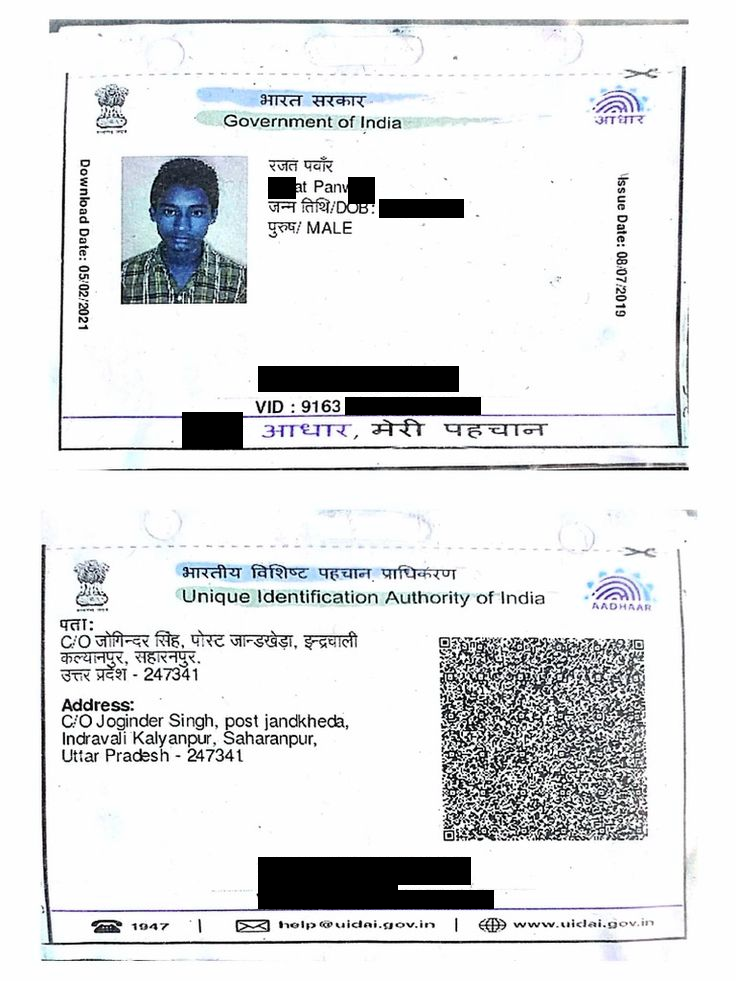

In [27]:
Image.fromarray(masked_img)

In [28]:
# Basic usage
masker = FixedAadhaarMasker('/Users/junaid/Documents/projects/SpaceMarvel/owl-masker/samples/Aadhaar_letter_large.png')

# Mask everything
masked_img, items = masker.mask_elements(['aadhaar_number', 'date_of_birth', 'name', 'address'])

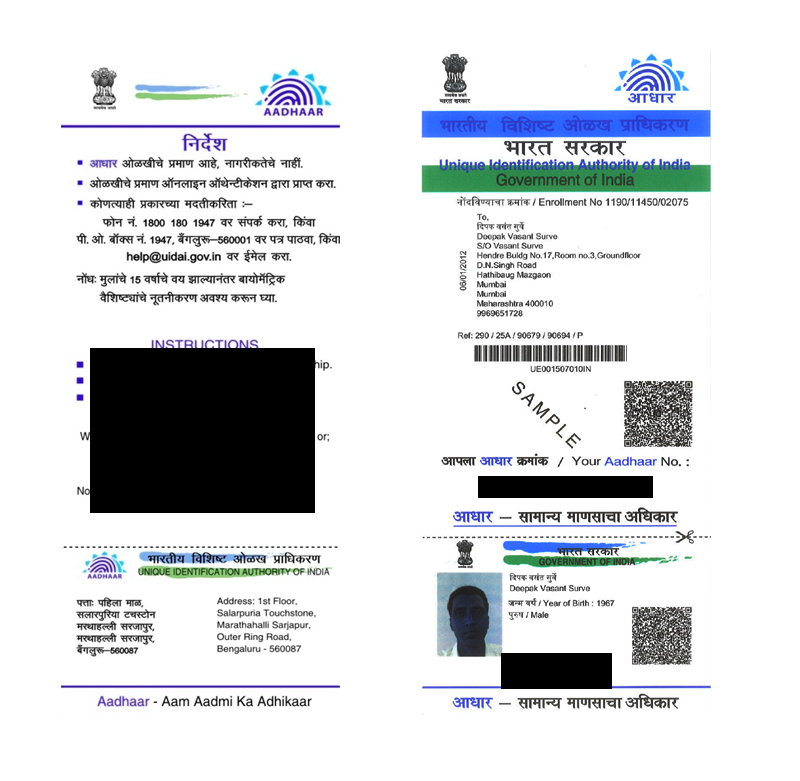

In [29]:
Image.fromarray(masked_img)
